#### Decision Tree Classification on Cellular Glioblastoma (GBM)

##### What is GBM?
A highly aggressive brain tumor that originates from glial cells in the brain or spinal cord. GMB is marked by significant variability within and between tumors. Tumor cells from the core and periphery share molecular signatures, complicating treatment and driving recurrence. 

#### Therapeutic Challenges:
Current treatments (surgery, radiotherapy, and chemotherapy) extend survival but are often insufficient, as GBM tends to recur within two years.

The diffuse nature of the tumor allows neoplastic cells to spread far, making localized treatments less effective.

Immunotherapy has had limited success in treating GBM due to the tumor's immunosuppressive environment.

#### Machine Learning Classification Task

The goal of this project is to use a Decision Tree algorithm to classify: 

1. Immune cells in the core vs. the periphery of the tumor

2. Neoplastic cells in the core vs. the periphery

Dataset: scRNA-Seq Data from four Glioblastoma (GBM) collected by Darmanis et al. (2017)

#### Project Requirements

A. Parameter Optimization: Improve the Decision Tree algorithm's performance through hyperparameter tuning

B. Handling Class Imbalance: Implement methods to address imbalanced data and assess their impact on performance.

C. Result Discussion: Analyze and discuss the results using various performance metrics.

Goal: To develop a reliable classification model to differentiate between normal and neoplastic cells, providing insights that can guide future therapies targeting not only tumor cells but also infiltrating cell populations responsible for recurrence. 

In [34]:
import pandas as pd
import numpy as np
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt

#Metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef


 
# Customize Seaborn's default styles with specific parameters
rc = {'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc) 

# Set pandas display options to limit the number of rows displayed to 10
pd.set_option("display.max_rows", 10)

# Disable the chained assignment warning in pandas
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('gbm_tsn.csv')

# Display the first few rows of the dataframe
print(data.head(10))

          F1         F2  Class     F3               F4
0  19.555715 -66.420423  Tumor  BT_S2       Neoplastic
1 -66.467768  -4.840194  Tumor  BT_S2  Oligodendrocyte
2   8.197811 -63.763646  Tumor  BT_S2       Neoplastic
3  -6.468824 -51.283635  Tumor  BT_S2       Neoplastic
4  -9.436247 -53.896430  Tumor  BT_S2       Neoplastic
5  -9.937541 -58.177118  Tumor  BT_S2       Neoplastic
6  16.746660 -71.034181  Tumor  BT_S2       Neoplastic
7 -37.511110  37.406128  Tumor  BT_S2              opc
8  -0.217017 -52.338028  Tumor  BT_S2       Neoplastic
9  18.883817 -70.713328  Tumor  BT_S2       Neoplastic


In [15]:
print(data.describe()) #For Numeric Columns F1 and F2 our cell location.....

                 F1            F2
count  3.589000e+03  3.589000e+03
mean   1.838996e-11 -6.408276e-12
std    2.871176e+01  3.717676e+01
min   -7.334338e+01 -7.529567e+01
25%   -1.548707e+01 -3.210212e+01
50%    2.259670e+00  7.872693e+00
75%    2.024714e+01  3.122181e+01
max    5.946896e+01  6.072984e+01


In [16]:
print(data.groupby('Class').size()) #Class column, Tumor or Periphery

Class
Periphery    1246
Tumor        2343
dtype: int64


In [14]:
print(data.groupby('F4').size()) #F4 is our cell type column

F4
Astrocyte            88
Immune             1847
Neoplastic         1091
Neuron               21
Oligodendrocyte      85
Vascular             51
opc                 406
dtype: int64


In [24]:
data.shape #Verifying shape of the original dataset

#Important to note as shape will change when we introduce resample

(3589, 5)

##### Class Imbalance

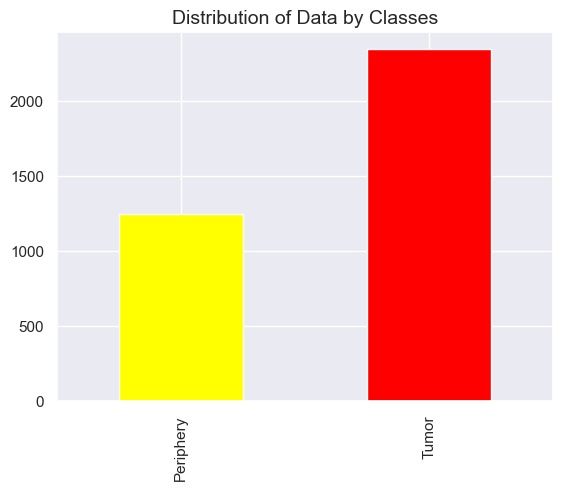

In [4]:
# Check the distribution of the 'Class' column to understand the class imbalance
class_distribution = data['Class'].value_counts()

# Display the distribution
class_distribution

# Assign colors and labels to the bars
patterns_colors = ['yellow', 'red']  # Match with Periphery (yellow) and Tumor (red)
patterns_labels = ['Periphery', 'Tumor']

# Align the counts with the labels
patterns_counts = class_distribution.sort_index()
patterns_counts.index = patterns_labels

# Plot the distribution as a bar chart
patterns_counts.plot(
    kind='bar',
    color=patterns_colors,
    title='Distribution of Data by Classes'
)

# Display the plot
plt.show()

In [5]:
patterns_counts

Periphery    1246
Tumor        2343
Name: count, dtype: int64

##### As you can see imbalance.....


##### How to try imbalance data

1. Up-sample Minority Class
Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

There are several heuristics for doing so, but the most common way is to simply resample with replacement.

First, we'll import the resampling module from Scikit-Learn:

Next, we'll create a new DataFrame with an up-sampled minority class. Here are the steps:

First, we'll separate observations from each class into different DataFrames.
Next, we'll resample the minority class with replacement, setting the number of samples to match that of the majority class.
Finally, we'll combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [22]:
#What is the majority Class size (to upsample the smaller class?)
majority_class = data['Class'].value_counts().max()

#Tumor is our "majority" class
tumor = data[data['Class'] == 'Tumor']

periphery_up = resample(
    data[data['Class'] == 'Periphery'],
    replace=True, #Sampling With Replacement
    n_samples=majority_class, #Should be the size of tumor
    random_state=123
)

#Combined the Tumor Class with the upsampled Periphery Class
data_balanced = pd.concat([tumor, periphery_up])

#Verification
print(data_balanced['Class'].value_counts())

Class
Tumor        2343
Periphery    2343
Name: count, dtype: int64


#### Why ? fix class imbalance
Avoids bias in the model, improved generalization

Under vs. upsampling
Preserves Data, synthetically create new samples for the minority class. (no information loss)

Better for small datasets, undersampling would reduce the number of majority class (Tumors)

#### Filtering Immune Vs. Neoplastic

In [49]:
# Filter only immune and neoplastic cells from the dataset
immune_data = data_balanced[data_balanced['F4'] == 'Immune']
neoplastic_data = data_balanced[data_balanced['F4'] == 'Neoplastic']

# Combine the two filtered datasets
filtered_data = pd.concat([immune_data, neoplastic_data])

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Apply OneHotEncoder to 'F3' and 'F4'
encoded_features = encoder.fit_transform(filtered_data[['F3', 'F4']])

# Create a DataFrame from the encoded features
encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(['F3', 'F4']),
    index=filtered_data.index  # Ensure indices match the filtered DataFrame
)

# Concatenate encoded features with the original numerical columns (F1 and F2)
X = pd.concat([filtered_data[['F1', 'F2']], encoded_df], axis=1)

# Extract the target label (Class) from the filtered data
y = filtered_data['Class'].values

# Verify the shape of the feature matrix and labels
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Features shape: (3598, 6)
Labels shape: (3598,)


Our features and labels now spilt into X and y, the categorical values have been encoded, balanced the unbalanced data to hopefully raise the accuracy score.

#### Decision Tree
train_test_split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Simple DTC no Hyperparameter Tuning

In [51]:
tree = DecisionTreeClassifier() # decision tree algorithm
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [52]:
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.') 
print(f'Model Accuracy: {tree.score(X_train, y_train)}')

Decision tree has 253 nodes with maximum depth 18.
Model Accuracy: 1.0


Possible sign of overfitting here on the training set may indicated it has learned the training data a little too well.

In [53]:
y_pred = tree.predict(X_test) 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

   Periphery       0.95      0.98      0.97       330
       Tumor       0.99      0.97      0.98       570

    accuracy                           0.97       900
   macro avg       0.97      0.98      0.97       900
weighted avg       0.97      0.97      0.97       900



The accuracy here is very high ~96%, this prediction is before optimizing the data now we will optimize the data and check the result. Model may be overfitting with such a high accuracy.

#### Decision Tree (Optimization / Hyperparam Tuning)

In [54]:
param_grid = { 'max_depth': [2, 3, 4, 5, 6, 7], 'min_samples_leaf': [2, 20, 50,70], 
               'max_leaf_nodes': [5, 9, 15, 21, 27]}
gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gs_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_leaf_nodes': [5, 9, 15, 21, 27],
                         'min_samples_leaf': [2, 20, 50, 70]})

Best Estimator

In [55]:
print(f'The best model is: \n{gs_dt.best_estimator_}')

The best model is: 
DecisionTreeClassifier(max_depth=7, max_leaf_nodes=27, min_samples_leaf=2)


In [56]:
tree_opt = gs_dt.best_estimator_
print(f'Decision tree has {tree_opt.tree_.node_count} nodes with maximum depth {tree_opt.tree_.max_depth}.') 
print(f'Model Accuracy: {tree_opt.score(X_train, y_train)}')

Decision tree has 53 nodes with maximum depth 7.
Model Accuracy: 0.9651593773165308


Confusion Matrix

In [ ]:
#Confusion Matrix on Tuned
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

ROC (Receiver Operating Characteristic) curve plots the True Positive Rate (TPR) VS. the FPR (False Positive Rate)

AUC (Area Under Curve)

In [61]:
# Calculate the ROC AUC Score (requires probabilities)
y_prob = tree.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_score:.2f}")

ROC AUC Score: 0.98


ROC AUC SCORE: The model has great discriminatory ability. Model is very good at distinguishing between Tumor Vs. Periphery. Very few false positives and false negatives.

Classification Report

In [57]:
y_pred = tree_opt.predict(X_test) 
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

   Periphery       0.94      0.94      0.94       330
       Tumor       0.96      0.96      0.96       570

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



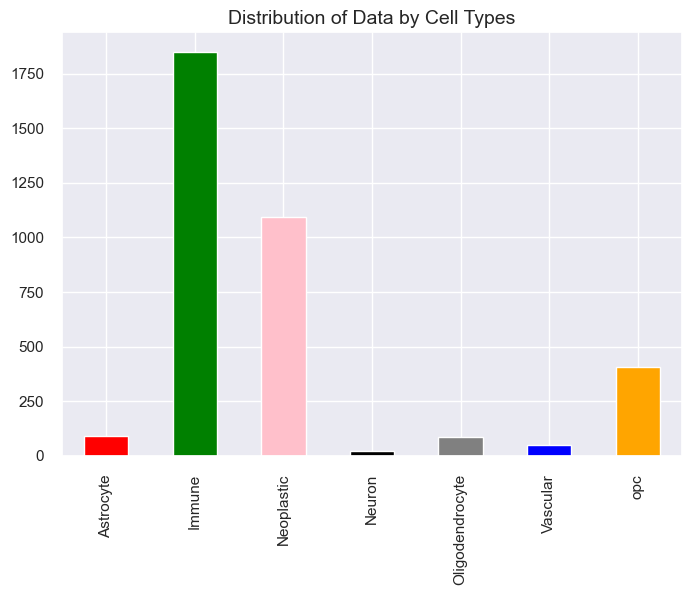

In [58]:
# Create a copy of the original DataFrame 'data' to 'gbm_data'
gbm_data = data.copy()

# Extract y (target) and X (features) from the original dataset
y = gbm_data['F4'].values
X = gbm_data.drop(['Class', 'F3', 'F4'], axis=1)

# Define colors and labels for the plot
patterns_colors = ['red', 'green', 'pink', 'black', 'gray', 'blue', 'orange']
patterns_labels = ['Astrocyte', 'Immune', 'Neoplastic', 'Neuron', 
                   'Oligodendrocyte', 'Vascular', 'opc']

# Get counts of unique values in 'F4' and align with the defined labels
patterns_counts = gbm_data['F4'].value_counts().sort_index()
patterns_counts.index = patterns_labels

# Plot the distribution of cell types as a bar chart
patterns_counts.plot(
    kind='bar',
    color=patterns_colors,
    title='Distribution of Data by Cell Types'
)

# Display the plot
plt.show()


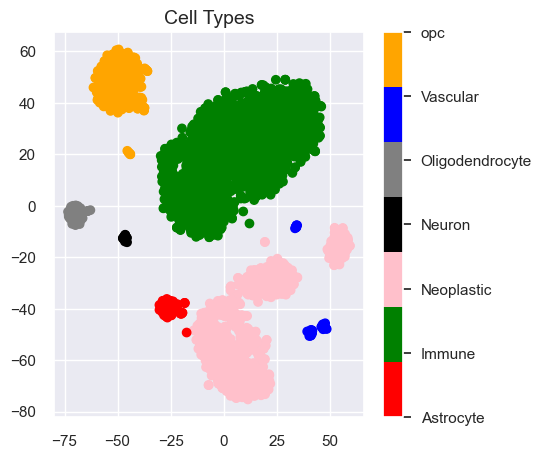

In [59]:
import matplotlib.colors as mcolors

#Prepare the data from the copied dataFrame
X1 = gbm_data['F1'].values
X2 = gbm_data['F2'].values

# Define cell types and corresponding colors
cells = ("Astrocyte", "Immune", "Neoplastic", "Neuron", 
         "Oligodendrocyte", "Vascular", "opc")
colors = ("red", "green", "pink", "black", "gray", "blue", "orange")

# Convert the labels in 'F4' to numerical values for plotting
label_mapping = {label: idx for idx, label in enumerate(cells)}
true_labels = np.array([label_mapping[label] for label in gbm_data['F4']])

# Create the scatter plot
fig = plt.figure(figsize=(5, 5))
plt.scatter(X1, X2, c=true_labels, cmap=mcolors.ListedColormap(colors))

# Add a colorbar with appropriate labels
cb = plt.colorbar()
loc = np.linspace(0, max(true_labels), len(colors))  # Adjust tick locations
cb.set_ticks(loc)
cb.set_ticklabels(cells)

# Set plot title and display the plot
plt.title('Cell Types')
plt.show()